In [2]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = '3, 5, 7'
import json
import torch
import random
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw, ImageFont
from torch import nn
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import torchvision
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform
from skimage.util import crop
import albumentations as A
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [2]:
def data_parcing(data_path, data_sample = '/train/'):
    boxes_file = {'/train/': 'od_training.csv',
                 '/validation/': 'od_validation.csv'}
    images = []
    k = 0
    l = 0
    t = 0
    boxes_labels = {}
    labelmap = {'background': 0, 'hand': 1, 'instance': 2}
    rev_labelmap = {0: 'background', 1: 'hand', 2: 'instance'}
    data_labels = pd.read_csv(data_path + data_sample + boxes_file[data_sample], 
                              names=['image', 'x1', 'y1', 'x2', 'y2', 'class'])
    for image in os.listdir(data_path + data_sample + '/data/images'):
        img_nm = data_path + data_sample + 'data/images/' + image
        images.append(img_nm)
        boxes_labels[img_nm] =  {'boxes':[],
                                 'labels':[]}
    for index, row in data_labels.iterrows():
        boxes_labels[data_path + data_sample +row['image']]['boxes'].append(list(row[['x1', 'y1', 'x2', 'y2']]))
        boxes_labels[data_path + data_sample +row['image']]['labels'].append(labelmap[row['class']])
    return labelmap, rev_labelmap, images, boxes_labels

In [3]:
data_path = '/data/akbulygin/det/'

In [4]:
labelmap, rev_labelmap, train_images, train_targets = data_parcing(data_path)

In [5]:
_, _, val_images, val_targets = data_parcing(data_path, '/validation/')

In [6]:
import math
import matplotlib.patches as patches
def as_list(x):
    if type(x) is int:
        return [x]
    else:
        return x
    
def img_show(dataset, idxes, preds=None):
    idxes = as_list(idxes)
    idxes = np.array(idxes)
    num_idxes = len(idxes)
    num_cols = 3
    num_rows = math.ceil(num_idxes / num_cols)
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(25, num_rows * 5))
    for i, idx in enumerate(idxes):
        im, label = dataset.getitem_notransform(idx)
        # im_name=dataset_manager.get_class(label)
        ax.flat[i].imshow(im, animated=True)
        # print(label['boxes'])
        for num_obj, bb in enumerate(label['boxes']):
            # print(len(label['labels']))
            if label['labels'][num_obj] == 0:
                rect = patches.Rectangle((bb[0], bb[3]), bb[2] - bb[0], bb[1] - bb[3], 
                                         linewidth=1, edgecolor='b', facecolor='none')
            else: 
                rect = patches.Rectangle((bb[0], bb[3]), bb[2] - bb[0], bb[1] - bb[3],
                                             linewidth=1, edgecolor='r', facecolor='none')
                ax.flat[i].add_patch(rect)

In [7]:
def img_show2(images, targets, num_cols = 3, preds=None):
    #idxes = as_list(idxes)
    #idxes = np.array(idxes)
    num_idxes = len(images)
    num_rows = math.ceil(num_idxes / num_cols)
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i in range(len(images)):
        #im, label = dataset[idx]
        # im_name=dataset_manager.get_class(label)
        ax.flat[i].imshow(images[i], animated=True)
        # print(label['boxes'])
        for num_obj, bb in enumerate(targets[i]['boxes']):
            # print(len(label['labels']))
            if targets[i]['labels'][num_obj] == 1:
                rect = patches.Rectangle((bb[0], bb[3]), bb[2] - bb[0], bb[1] - bb[3], 
                                         linewidth=1, edgecolor='b', facecolor='none')
            else: 
                rect = patches.Rectangle((bb[0], bb[3]), bb[2] - bb[0], bb[1] - bb[3],
                                             linewidth=1, edgecolor='r', facecolor='none')
                ax.flat[i].add_patch(rect)

In [8]:
class FoodDataSet(Dataset):
    def __init__(self, images, targets, transform_A, transform_tensor=None):
        self.images = images
        self.targets = targets
        self.transform_A = transform_A
        self.transform_tensor = transform_tensor
 
    def __len__(self):
        return len(self.images)
 
    def getitem_notransform(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.images[idx]
        image = io.imread(img_name)
        target = self.targets[img_name]
        sample = [image, target]
        sample = self.transform_A(image=sample[0], bboxes=sample[1]["boxes"], labels=sample[1]["labels"])
        sample = [sample["image"],
                    {"boxes": sample["bboxes"],
                    "labels": sample["labels"]}]
        return sample
 
    def __getitem__(self, idx):
        image, target = self.getitem_notransform(idx)
        image = FT.to_tensor(image)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = FT.normalize(image, mean=mean, std=std)
        target['boxes'] = torch.tensor(target['boxes'])
        target['labels'] = torch.tensor(target['labels'])
        return image, target
## DataSets
th = (200, 200, 1100, 1080)  ## croped image is (880, 900, 3)
batch_size = 32
datasets = {  ## Your is
    "train": FoodDataSet(train_images, train_targets, transform_A=A.Compose(
            [A.Crop(x_min=th[0], y_min=th[1], x_max=th[2], y_max=th[3], always_apply=True)],
            bbox_params=A.BboxParams(format="pascal_voc", min_area=1024, min_visibility=0.3, label_fields=["labels"])),
    ),
    "test": FoodDataSet(val_images, val_targets,
            transform_A=A.Compose(
            [A.Crop(x_min=th[0], y_min=th[1], x_max=th[2], y_max=th[3], always_apply=True)],
            bbox_params=A.BboxParams(format="pascal_voc", min_area=1024,
                min_visibility=0.3, label_fields=["labels"]),
        ),
    ),
}

def collate_fn(batch):
    return tuple(zip(*batch))
 
dataloaders = {
    "train": DataLoader(
        dataset=datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn,
    ),
    "test": DataLoader(
        dataset=datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn,
    ),
}
 

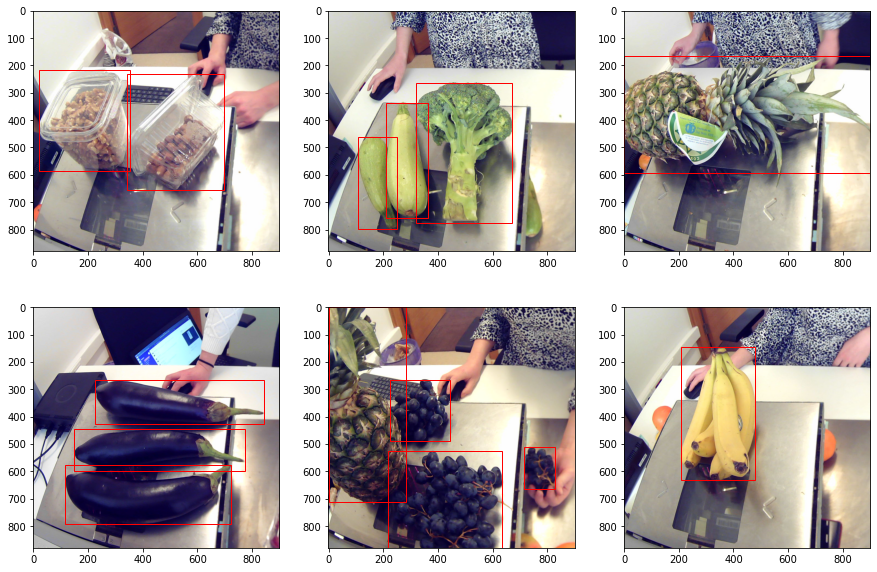

In [9]:
indexes = [2, 23, 153, 790, 33, 532]
test_data = [datasets['train'].getitem_notransform(i) for i in indexes]
imgs = [test_data[i][0] for i in range(len(indexes))]
trgts = [test_data[i][1] for i in range(len(indexes))]
##img_show(datasets['train'], [2, 23, 153, 790, 33, 532])
img_show2(imgs, trgts)

In [10]:
def saving(epoch, model, optimizer, pth = 'checkpoint.pth.tar'):
    torch.save({'epoch' : epoch,
            'model': model,
            'optimizer': optimizer,
            }, pth)

In [11]:
loss_by_epoch = []
def train(train_loader, model, optimizer, start_epoch, last_epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.to(device)
    model.train()  
    # Batches
    for num_epoch in tqdm(range(start_epoch, last_epoch)):
        epoch_loss = 0
        for images, targets in tqdm(train_loader):
            torch.cuda.empty_cache()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward prop.
            loss_dict = model(images, targets) 

            losses = sum(loss for loss in loss_dict.values())

            # Backward prop.
            optimizer.zero_grad()
            losses.backward()

            # Update model
            optimizer.step()
            torch.cuda.empty_cache()
            epoch_loss += losses
            del images, targets, loss_dict
        saving(num_epoch, model, optimizer)
        epoch_loss.to('cpu')
        if num_epoch % 10 == 0:    
            print(epoch_loss.item())
        loss_by_epoch.append(epoch_loss.item())

In [12]:
learning_rate = 0.001
num_epoch = 100
momentum = 0.9
weight_decay = 0.00001

In [13]:
model = None
optimizer = None
checkpoint_path = 'checkpoint.pth.tar'
if checkpoint_path == None:
    model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=3)
    for param in model.backbone.parameters():
        param.requires_grad = False
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate,
                                momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint_path)
    last_epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']

In [50]:
train(dataloaders['train'], model, optimizer, num_epoch * 3, num_epoch * 5)


7.851017951965332



7.8043532371521



7.95993709564209



7.107015132904053


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




5.668872833251953



5.358668327331543



6.091428279876709



5.194177627563477



5.121153354644775



4.980770111083984



4.885828495025635



4.74041748046875


In [44]:
def evaluation(model, dataset, indexes = [0]):
    model.eval()
    model.to('cpu')
    for i in indexes:
        img_for_mdl, real_boxes = datasets['test'][i]
        with torch.no_grad():
            preds = model([img_for_mdl])
        preds = preds[0]
        nms_preds = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.5)
        #print(preds['boxes'][nms_preds['boxes']])
        result = {}
        res_indexes = []
        for j in nms_preds:
            if preds['scores'][j] > 0.5:
                res_indexes.append(j.item())
        
        result['boxes'] = preds['boxes'][res_indexes]
        result['labels'] = preds['labels'][res_indexes]
        img_for_draw = datasets['test'].getitem_notransform(i)[0]
        img_show2([img_for_draw, img_for_draw], [real_boxes, result], 2)
    model.to(device)

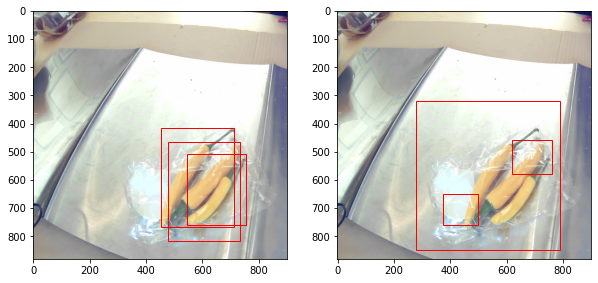

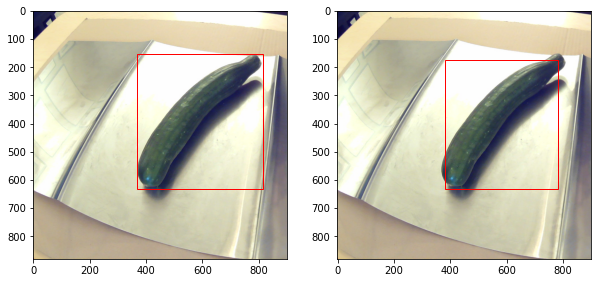

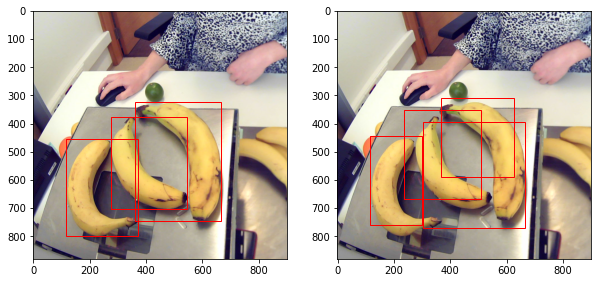

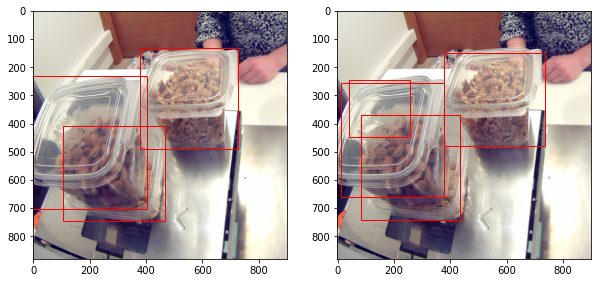

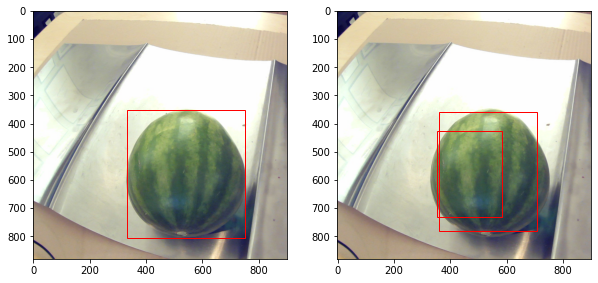

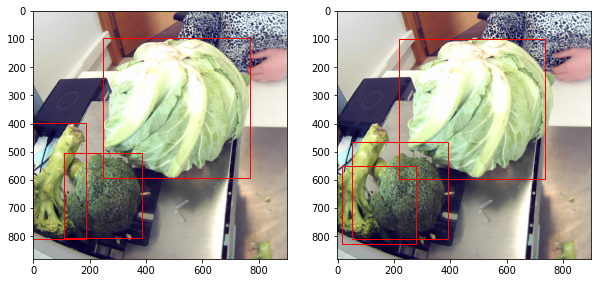

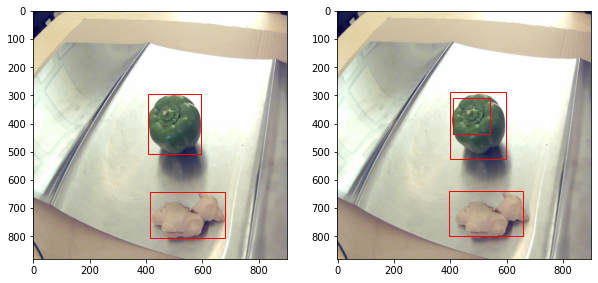

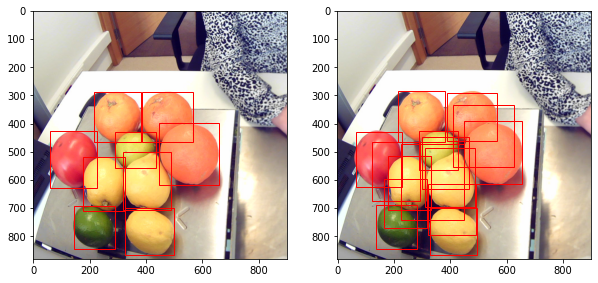

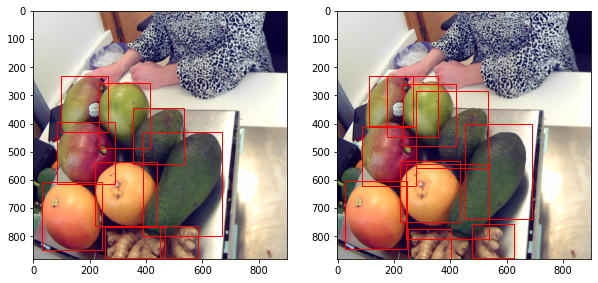

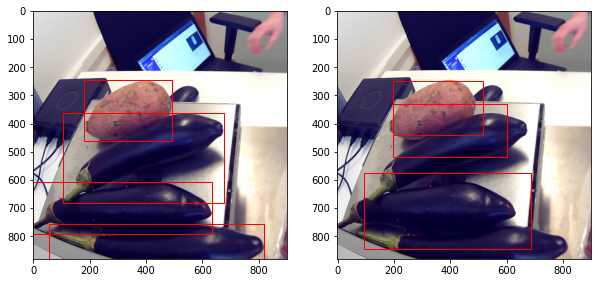

In [56]:
evaluation(model, datasets['test'], indexes = np.random.permutation(np.arange(len(datasets['test'])))[:10])

In [52]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [53]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels) # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(labelmap)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_images.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if true_class_boxes_detected[original_ind] == 0:
                    true_positives[d] = 1
                    true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                # Otherwise, it's a false positive (since this object is already accounted for)
                else:
                    false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / true_class_images.size(0)  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_labelmap[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [57]:
from pprint import PrettyPrinter
pp = PrettyPrinter()

det_boxes = []
det_labels = []
det_scores = []
true_boxes = []
true_labels = []

model.eval()
model.to('cpu')
for i in tqdm(range(len(datasets['test']))):
    image, true_targets = datasets['test'][i]
    preds = model([image])
    preds = preds[0]
    #nms_preds = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.1)
    det_boxes.append(preds['boxes'])
    det_labels.append(preds['labels'])
    det_scores.append(preds['scores'])
    true_boxes.append(true_targets['boxes'])
    true_labels.append(true_targets['labels'])



In [55]:
APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels)

# Print AP for each class
pp.pprint(APs)

print('\nMean Average Precision (mAP): %.3f' % mAP)

{'hand': 0.8840966820716858, 'instance': 0.8342412710189819}

Mean Average Precision (mAP): 0.859


In [1]:
def detect(image_path, model):
    th = (200, 200, 1100, 1080)
    transform_A = A.Compose([A.Crop(x_min=th[0], y_min=th[1], x_max=th[2], y_max=th[3], always_apply=True)])
    image = io.imread(image_path)
    image = transform_A(image=image)
    image_for_model = FT.to_tensor(image)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_for_model = FT.normalize(image_for_model, mean=mean, std=std)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    image_for_model.to(device)
    preds = model([image_for_model])[0]
    nms_preds = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.5)
    result = {'boxes': preds['boxes'][nms_preds],
             'labels': preds['labels'][nms_preds],
             'scores': preds['scores'][nms_preds]}
    return result

In [3]:
import sys
if __name__ == '__main__':
    assert len(sys.argv) > 1
    img_path = sys.argv[1]
    checkpoint_path = 'checkpoint.pth.tar'
    checkpoint = torch.load(checkpoint_path)
    model = checkpoint['model']
    print(detect(img_path, model))

FileNotFoundError: No such file: '/home/akbulygin/x5/-f'

In [14]:
image_path = '/data/akbulygin/det/validation/data/images/2021-02-16_16-55-54-272370.jpeg'
th = (200, 200, 1100, 1080)
transform_A = A.Compose([A.Crop(x_min=th[0], y_min=th[1], x_max=th[2], y_max=th[3], always_apply=True)])
image = io.imread(image_path)
image = transform_A(image=image)['image']
#print(image)
image_for_model = FT.to_tensor(image)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_for_model = FT.normalize(image_for_model, mean=mean, std=std)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = 'checkpoint.pth.tar'
checkpoint = torch.load(checkpoint_path)
model = checkpoint['model']
    
model.eval()
model.to(device)
image_for_model = image_for_model.to(device)
preds = model([image_for_model])[0]
nms_preds = torchvision.ops.nms(preds['boxes'], preds['scores'], iou_threshold=0.5)
result = {'boxes': preds['boxes'][nms_preds].to('cpu'),
         'labels': preds['labels'][nms_preds].to('cpu'),
         'scores': preds['scores'][nms_preds].to('cpu')}
result

{'boxes': tensor([[384.1527, 490.9229, 540.7575, 662.1796],
         [562.2356, 428.2226, 711.6743, 601.5001],
         [493.6913, 441.3101, 679.6671, 611.3469],
         [401.1982, 443.5378, 548.1511, 606.0393],
         [271.7059, 252.6145, 700.8959, 714.1943],
         [  7.4246,   0.0000, 146.0791, 117.6145]], grad_fn=<CopyBackwards>),
 'labels': tensor([2, 2, 2, 2, 2, 1]),
 'scores': tensor([0.9996, 0.9992, 0.1518, 0.0697, 0.0604, 0.0515],
        grad_fn=<CopyBackwards>)}